In [38]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [40]:
g = torch.Generator().manual_seed(2147483647)

In [41]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3080 Laptop GPU


In [43]:
words = open('names.txt', 'r').read().splitlines()

In [44]:
chars = ['.'] + sorted(list(set(''.join(words))))
encode = lambda c: chars.index(c)
decode = lambda i: chars[i]

In [45]:
block_size = 3
vocab_size = len(chars)

In [46]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = encode(c)
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Getting the initial loss function right

11897
      0/ 200000: 25.0534
  10000/ 200000: 2.5154
  20000/ 200000: 2.3246
  30000/ 200000: 2.3359
  40000/ 200000: 2.3783
  50000/ 200000: 2.3355
  60000/ 200000: 2.2633
  70000/ 200000: 2.3177
  80000/ 200000: 2.6525
  90000/ 200000: 2.7191
 100000/ 200000: 2.0307
 110000/ 200000: 2.2111
 120000/ 200000: 2.2525
 130000/ 200000: 1.9685
 140000/ 200000: 2.0442
 150000/ 200000: 2.2161
 160000/ 200000: 2.4536
 170000/ 200000: 2.5352
 180000/ 200000: 2.2406
 190000/ 200000: 2.3654


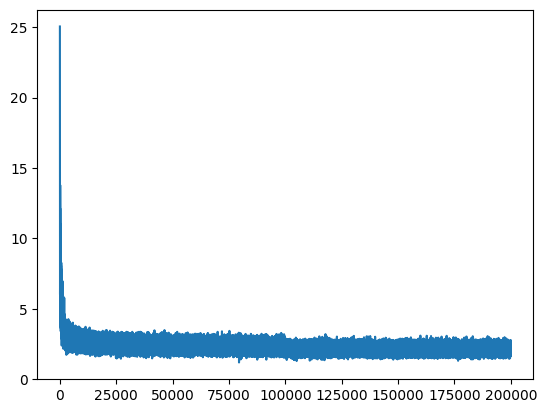

In [24]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())

_ = plt.plot(lossi)


In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = x @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0557446479797363
val 2.1152327060699463


The initial high loss is a clear signal that there is an issue with the way how we initalize the weights. Initally, the network is very confidently wrong, as indicated by high negative log likelihood. 
Based on the problem stement, we know what the initial loss should roughly be. At the very beginning, the distribution that the network predicts should be roughly uniform - every character should have roughly the same probability of being predicted, since we have not learned anything yet. This observation allows us to calculate the expected starting loss:

<pre>
probability per character = 1/27
-log(1/27) = 3.29
</pre>

So the right starting point should be roughly 3.29.

So we want the logits to be roughly the same for each character, meaning the entroppy is low and everything is equally likely. We can achieve it by setting the bias of the output layeer to zero, and the output weights to some small numbers, hence making the logits very small:

<pre>
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
</pre>

11897
      0/ 200000: 3.3546
  10000/ 200000: 2.3045
  20000/ 200000: 2.3450
  30000/ 200000: 2.4342
  40000/ 200000: 1.7839
  50000/ 200000: 2.2045
  60000/ 200000: 2.5444
  70000/ 200000: 2.3300
  80000/ 200000: 2.3300
  90000/ 200000: 1.8308
 100000/ 200000: 2.1857
 110000/ 200000: 1.9138
 120000/ 200000: 2.4413
 130000/ 200000: 2.5031
 140000/ 200000: 1.8548
 150000/ 200000: 1.8914
 160000/ 200000: 2.2948
 170000/ 200000: 2.2378
 180000/ 200000: 1.7533
 190000/ 200000: 2.0824


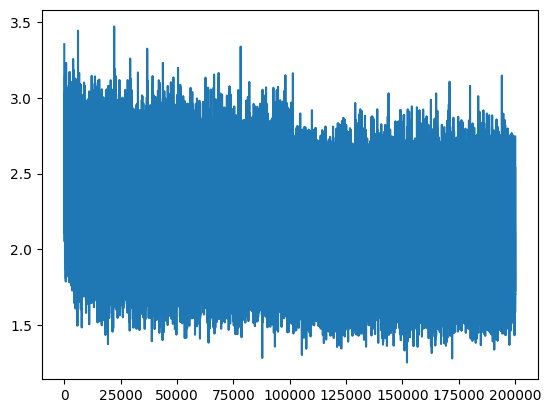

In [27]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())

_ = plt.plot(lossi)


Now we have taken away the easy part of the optimalization, and the plot of the loss function does not look like a hockey stick anymore. The hockey stick appearance means that the optmization was simply making the weights smaller.

Initial losses with softmax confidently wrong (random weight initialization without scaling):
<pre>
train 2.119840145111084
val 2.162057399749756
</pre>

After fixing softmax initially confidently wrong:
<pre>
train 2.069589138031006
val 2.131074905395508 (the improvement is because we spend more cycles actually optimizing the weights rather than just squashing them in the beginning)
</pre>

# Getting the activations right to prevent vanishing gradients

In [17]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())
  break

11897
      0/ 200000: 3.3097


The initial loss looks good. Howeve, there is now problem with the value of the hidden activations. Looking at the output of variable `h` after one iteration, we see this:

<pre>
tensor([[-0.9552,  1.0000, -1.0000,  ..., -0.8650,  0.9979, -1.0000],
        [ 0.7501,  0.9931,  1.0000,  ...,  1.0000,  0.9998, -1.0000],
        [-0.9996,  0.9997,  1.0000,  ...,  0.9999,  1.0000,  0.9981],
        ...,
        [-0.9929, -0.9945, -1.0000,  ...,  0.9998, -0.9365, -0.9711],
        [-0.5854, -0.9949,  0.5593,  ...,  0.6392, -0.1373,  1.0000],
        [-0.9479,  1.0000, -1.0000,  ..., -1.0000, -0.9999, -1.0000]],
       grad_fn=<TanhBackward0>)
</pre>

There seems to be many activations with value close to the negative or poistive one - the flat part of the tanh function. This effectively means that the local gradient is zero for these activations, blocking the gradients from flowing during the backpropagation. We can look at the histogram of the hidden activations to see that most of the activations are concentrated at the extreme values of -1 and 1.

![Histogram of hidden state activations](images/histogram1.png)

Such distribution of the activations is caused by the distribution of the pre activations values (`hpreact`) and in particular by the large standard deviation of the preactivations, which puts the inputs to the tanh function well in its flat region.

![Histogram of pre activations](images/hpreact1.png)


In [22]:
print(f"hpreact.mean(): {hpreact.mean()}, hpreact.std(): {hpreact.std()}")
print(f"h.mean(): {h.mean()}, h.std(): {h.std()}")

hpreact.mean(): 0.03950118646025658, hpreact.std(): 5.70084285736084
h.mean(): 0.0019816465210169554, h.std(): 0.9224614500999451


Because the variance of preactivations is so large, a lot of inputrs to the tanh function are in the flat, saturated region. Since the gradient flowing thorugh tanh always decreases by `1-t^2` factor (which is the derivative of tanh), if t is 1 the local gradient is 0. The concern is that if all the tanh outputs are in the flat regions, the gradients flowing backwards wil be fully blocked.

In the plot below, white pixels are inactive neurons and black pixels are inactive neurons (for a given batch example).

![Active/Inactive Neurons](images/dead1.png)

If the entire column is white, this means that for every example in the batch the activation is in the flat region, and the neuron is esentially dead. Such nerons will will never learn.

The good thing in this case is that for each neuron there is at least one example which triggers it, so all neuron will learn.

What can happen during training is that a high gradient knocks a neuron off into this dead space and from that point on, the neuron never learns.

To fix the issue of so many activations being in the dead space, the outputs of the linear layer before the activation function have to be smaller. In fact, we want them to be roughly guassian.

We want the value of this expression `hpreact = embcat @ W1 + b1 # hidden layer pre-activation` to be close to zero. It is okey to set the biases to something small which is not zero. We also want to squash the weights, but not set them to zero:

```
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
```

In [32]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())

11897
      0/ 200000: 3.4940
  10000/ 200000: 1.9201
  20000/ 200000: 2.1985
  30000/ 200000: 2.1613
  40000/ 200000: 1.9802
  50000/ 200000: 2.1550
  60000/ 200000: 2.4511
  70000/ 200000: 2.2300
  80000/ 200000: 2.2980
  90000/ 200000: 2.1072
 100000/ 200000: 2.1910
 110000/ 200000: 1.9414
 120000/ 200000: 2.2594
 130000/ 200000: 1.8581
 140000/ 200000: 1.9340
 150000/ 200000: 2.1302
 160000/ 200000: 1.7001
 170000/ 200000: 1.9541
 180000/ 200000: 1.9002
 190000/ 200000: 2.4037


Now the activations, preactivations and the inactive/active neurons look like that:

![Histogram of hidden state activations](images/histogram2.png)

![Histogram of pre activations](images/hpreact2.png)

![Active/Inactive neurons](images/dead2.png)

The activations are now not saturated, because the variance of the preactivations is lower.


Initial losses with softmax confidently wrong (random weight initialization without scaling):
<pre>
train 2.119840145111084
val 2.162057399749756
</pre>

After fixing softmax initially confidently wrong:
<pre>
train 2.069589138031006
val 2.131074905395508
</pre>

Fixing tanh too saturated at initialization:
<pre>
train 2.0557446479797363
val 2.1152327060699463
</pre>

# Kaiming initialization

tensor(0.0119) tensor(0.9908)
tensor(0.0097) tensor(3.0445)


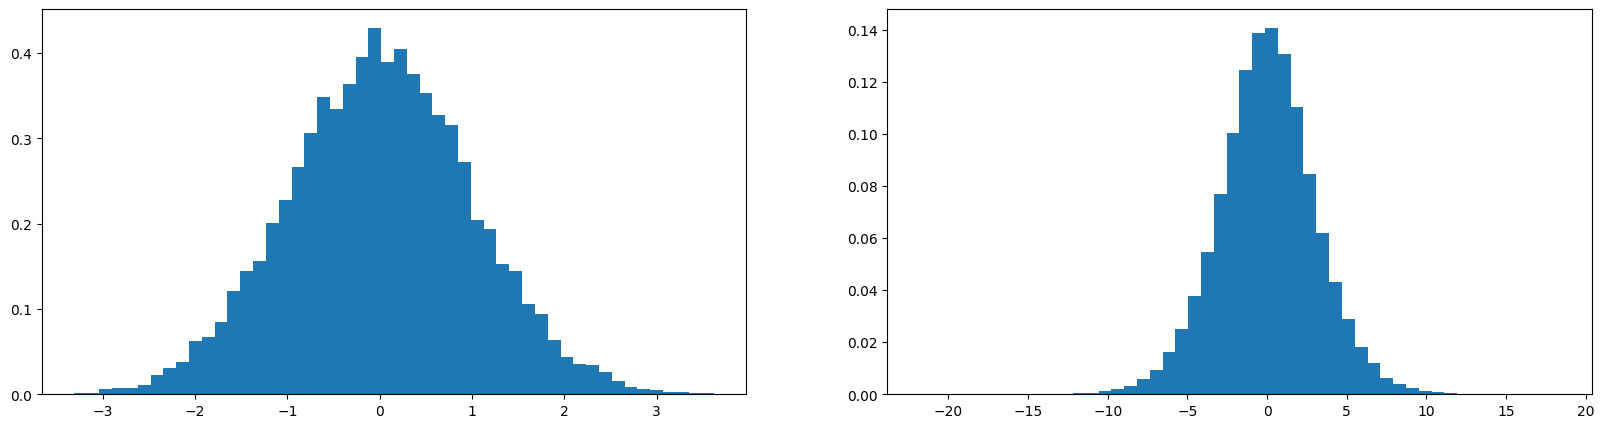

In [47]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y=x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
_ = plt.hist(y.view(-1).tolist(), 50, density=True);

When a gaussian input is multiplied by randomly initialized weights, the output is not a guassian anymore. It still has a mean of zero, but its standard devitions has increased.

<pre>
tensor(-0.0276) tensor(0.9942) <- input
tensor(-0.0105) tensor(3.2512) <- output
</pre>

We want most of the neural net to have roughly similar activations. So the question is, how do we scale the weights to preserve the gaussian output?

Lets multiply the weights by five `w = torch.randn(10, 200) * 5`:

The input and the output becomes:

<pre>
tensor(-0.0124) tensor(1.0053)
tensor(0.0279) tensor(15.9336)
</pre>

With  `w = torch.randn(10, 200) * 0.2`:

<pre>
tensor(0.0022) tensor(0.9950)
tensor(0.0012) tensor(0.6430)
</pre>

So the question is, how do we choose the scaling factors for the weights?

For a simple linear layer, divide by a square root of fan in (the input featueres). With such weight initializaition, for a raughly guassian input, the output will also be roughly gaussian.

For non linearities, you need to compensate for the discarded part of the distribution, so you also need a gain which depends ont he non linearity used. The scaling factor is basically ```gain/sqrt(fanin)```

For more details, refer to the Kaiming initialization paper on arXiv: https://arxiv.org/abs/1502.01852

Now the initalization of the weights for the preactivation function is:

```
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 * (n_embd * block_size)**-0.5
```

In [29]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 * (n_embd * block_size)**-0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())

11897
      0/ 200000: 3.7971
  10000/ 200000: 2.2270
  20000/ 200000: 2.2422
  30000/ 200000: 2.2745
  40000/ 200000: 2.0341
  50000/ 200000: 1.7015
  60000/ 200000: 2.2676
  70000/ 200000: 2.0063
  80000/ 200000: 2.2954
  90000/ 200000: 2.4001
 100000/ 200000: 1.8561
 110000/ 200000: 2.0723
 120000/ 200000: 1.8639
 130000/ 200000: 1.8688
 140000/ 200000: 1.9298
 150000/ 200000: 2.3193
 160000/ 200000: 2.0602
 170000/ 200000: 2.2118
 180000/ 200000: 2.0626
 190000/ 200000: 2.0679


Initial losses with softmax confidently wrong (random weight initialization without scaling):
<pre>
train 2.119840145111084
val 2.162057399749756
</pre>

After fixing softmax initially confidently wrong:
<pre>
train 2.069589138031006
val 2.131074905395508
</pre>

Fixing tanh too saturated at initialization:
<pre>
train 2.0355966091156006
val 2.102678060531616
</pre>

With kaiming intialization:
<pre>
train 2.0410633087158203
val 2.1087684631347656
</pre>

With Kaiming initialization we got to the same spot that we were at with magic numbers in a semi-structured way.

# Batch Normalization

Another way of normalizing the outputs of the layers is batch normalization, which is esentially used to control the statistics of the activations.

We want `hpreact` to be roughly gaussian - not to big to avoide the saturated space and not to small to avoid the linear part of tanh, which makes it inactive.

We can simply take the pre activations for the entire batch and normalize them.

However, we only want the preactivations to be normal gaussian at initialization. Then we want the neural net to be able to adjust the distribution during backpropagation. For this, we include learnable scale and shift parameters:

```
bngain = torch.ones(n_hidden)
bnbias = torch.zeros(n_hidden)
```

The benefit of batchnorm is that for very deep neural nets, settting the right scaling factors during initialization becomes intractable. With explicit form of normalization (batch norm) this is done automatically. 

It is common to include batch normalizatioin after layers with multiplications, such as linear layers or convolutional layers, to control the scale of activations without manual mathematics.

When using batch normalization, adding the bias to the layer being normalized is a wasteful operation, because in the end it will be removed during the normalization and added back again (in form of the learnable parameter).

So this line:
`hpreact = embcat @ W1 + b1 # hidden layer pre-activation` 
will become:
`hpreact = embcat @ W1 # hidden layer pre-activation` 

With small batch sizes, the stats might change significantly from iteration to iteration. Since the value is chaning aournd a lot, you dont want to take too much from any particular batch. Instead, you want to have large smooting, so the momentum should be kept low. With large batch sizes, it might be safe to keep the momentum relativlely high.

Batch normalization provides stability in neural networks, but at a cost. This cost involves a fundamental change in how neural networks process data. Originally, neural networks processed single examples deterministically. Batches were later introduced for training efficiency, but examples were still processed independently. Batch normalization couples examples within a batch mathematically. This coupling occurs in both forward and backward passes of the neural network.

Hidden state activations and logits for any input example now depend on the input example itself and all other examples in the batch. This leads to subtle changes or "jittering" in activations based on batch composition.

This "jittering" effect, initially seeming like a bug, turns out to be beneficial, because it acts as a regularizer for the neural network. The process introduces entropy into the system, acting as a form of data augmentation and making it harder for the neural network to overfit specific examples.

In [34]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 * (n_embd * block_size)**-0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros(n_hidden)
bnstd_running = torch.zeros(n_hidden)
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad(): # keeo the running stats
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())

12097
      0/ 200000: 3.4858
  10000/ 200000: 2.4437
  20000/ 200000: 2.1583
  30000/ 200000: 2.4405
  40000/ 200000: 2.3218
  50000/ 200000: 1.6986
  60000/ 200000: 2.2350
  70000/ 200000: 2.2101
  80000/ 200000: 1.8826
  90000/ 200000: 1.9384
 100000/ 200000: 1.9418
 110000/ 200000: 1.8950
 120000/ 200000: 2.2382
 130000/ 200000: 1.9526
 140000/ 200000: 2.3795
 150000/ 200000: 1.8391
 160000/ 200000: 1.9638
 170000/ 200000: 2.0640
 180000/ 200000: 2.0253
 190000/ 200000: 1.9956


In [35]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split, mean, std):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = x @ W1 + b1
  hpreact = bngain * (hpreact - mean) / std + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [36]:
with torch.no_grad():
    emb = C[Xtr]
    x = emb.view(emb.shape[0], -1)
    hpreact = x @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [37]:
print('running mean and std')
split_loss('train', bnmean_running, bnstd_running)
split_loss('val', bnmean_running, bnstd_running)

print('mean and std of all data')
split_loss('train', bnmean, bnstd)
split_loss('val', bnmean, bnstd)



running mean and std
train 2.0691652297973633
val 2.1119089126586914
mean and std of all data
train 2.0692460536956787
val 2.111602306365967


Initial losses with softmax confidently wrong (random weight initialization without scaling):
<pre>
train 2.119840145111084
val 2.162057399749756
</pre>

After fixing softmax initially confidently wrong:
<pre>
train 2.069589138031006
val 2.131074905395508
</pre>

Fixing tanh too saturated at initialization:
<pre>
train 2.0355966091156006
val 2.102678060531616
</pre>

With kaiming intialization:
<pre>
train 2.0376644134521484
val 2.106989622116089
</pre>

With batchnorm (and all previous improvements):
<pre>
train 2.0692460536956787
val 2.111602306365967
</pre>

With batchnorm and running means:
<pre>
train 2.0691652297973633
val 2.1119089126586914
</pre>

In [8]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) * (fan_in)**-0.5
        self.bias = torch.randn((fan_out), generator=g) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# batch norm
# we are using batch norm to control the statistics of the activation in the nn. 
# bn is usually applied after layers with multiplications, such as FC linear or CNN layers.
# bn has params for gain and bias, which are learnable parameters that scale and shift the output of the batch norm.
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = (x - xmean) / (xvar + self.eps).sqrt()
        self.out = self.out * self.gamma + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [18]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 2.1717
  10000/ 200000: 2.1307
  20000/ 200000: 1.9319
  30000/ 200000: 2.3601
  40000/ 200000: 2.1592
  50000/ 200000: 2.1219
  60000/ 200000: 2.1880
  70000/ 200000: 2.1163
  80000/ 200000: 2.0581
  90000/ 200000: 1.8156
 100000/ 200000: 1.8579
 110000/ 200000: 2.3122
 120000/ 200000: 2.0446
 130000/ 200000: 2.0879
 140000/ 200000: 1.5486
 150000/ 200000: 2.1922
 160000/ 200000: 2.0986
 170000/ 200000: 1.9721
 180000/ 200000: 1.7808
 190000/ 200000: 1.7803


layer 2 (      Tanh): mean +0.03, std 0.84, saturated: 43.00%
layer 5 (      Tanh): mean -0.00, std 0.91, saturated: 61.09%
layer 8 (      Tanh): mean -0.00, std 0.91, saturated: 61.78%
layer 11 (      Tanh): mean +0.03, std 0.93, saturated: 65.38%
layer 14 (      Tanh): mean +0.02, std 0.93, saturated: 66.72%


Text(0.5, 1.0, 'activation distribution')

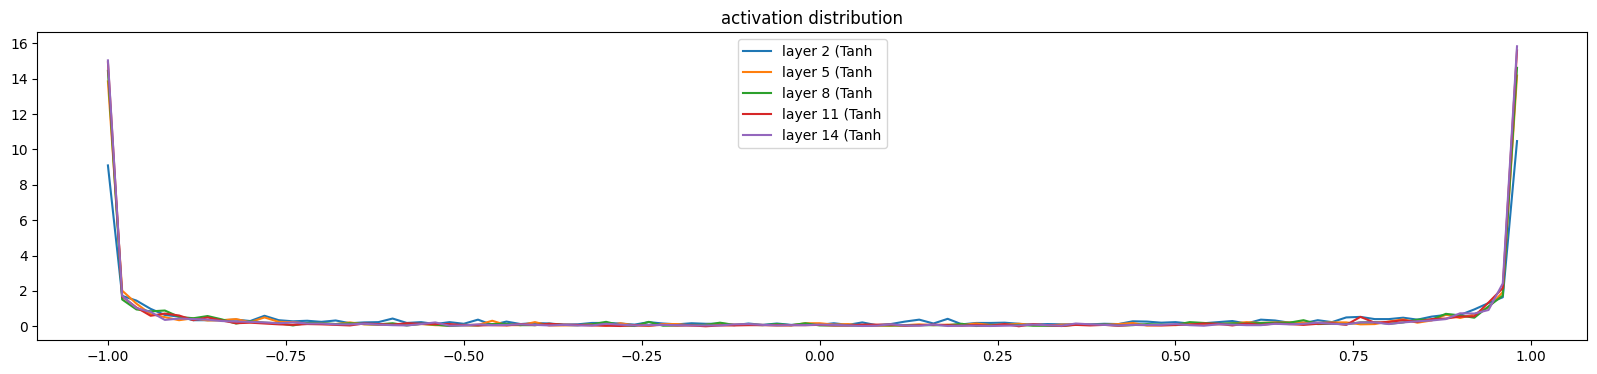

In [19]:
# visualize historgams for the forward pass
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000199, std 3.562495e-03
layer 5 (      Tanh): mean -0.000013, std 3.056477e-03
layer 8 (      Tanh): mean +0.000010, std 2.852256e-03
layer 11 (      Tanh): mean +0.000021, std 2.797823e-03
layer 14 (      Tanh): mean -0.000106, std 4.132515e-03


Text(0.5, 1.0, 'gradient distribution')

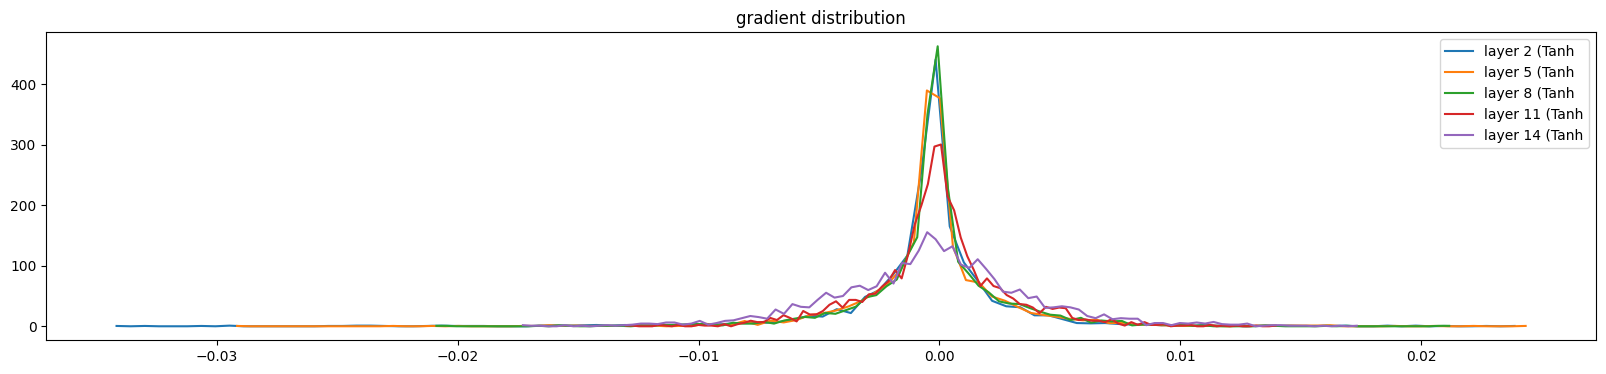

In [20]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.020533e-03 | grad:data ratio 8.012630e-03
weight  (30, 100) | mean +0.000246 | std 9.241074e-03 | grad:data ratio 4.881090e-02
weight (100, 100) | mean +0.000113 | std 7.132877e-03 | grad:data ratio 6.964617e-02
weight (100, 100) | mean -0.000086 | std 6.234301e-03 | grad:data ratio 6.073737e-02
weight (100, 100) | mean +0.000052 | std 5.742183e-03 | grad:data ratio 5.631479e-02
weight (100, 100) | mean +0.000032 | std 5.672204e-03 | grad:data ratio 5.570124e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


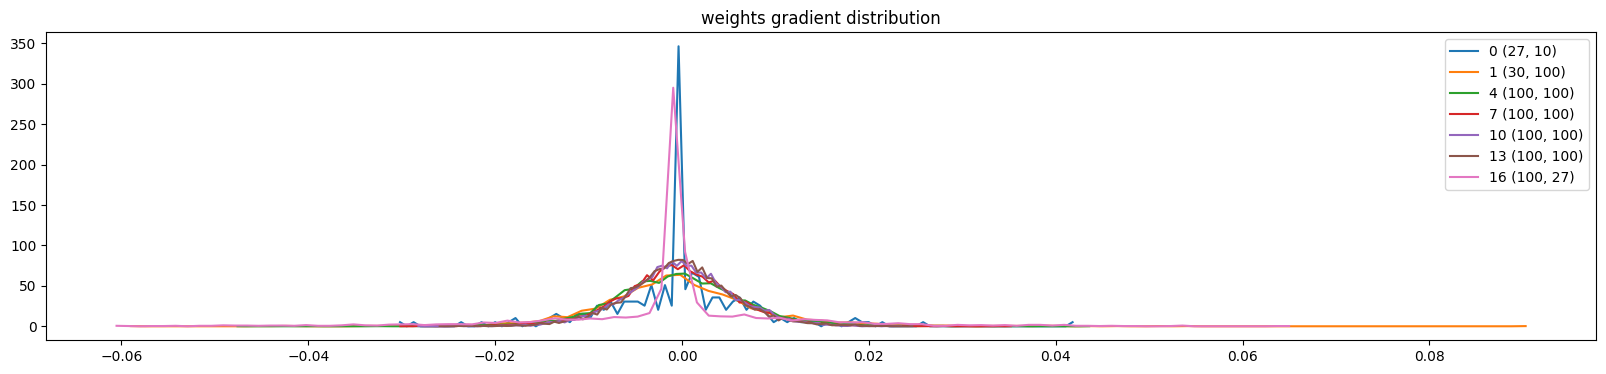

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

c:\Users\bstruzinski\source\repos\lite language model\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


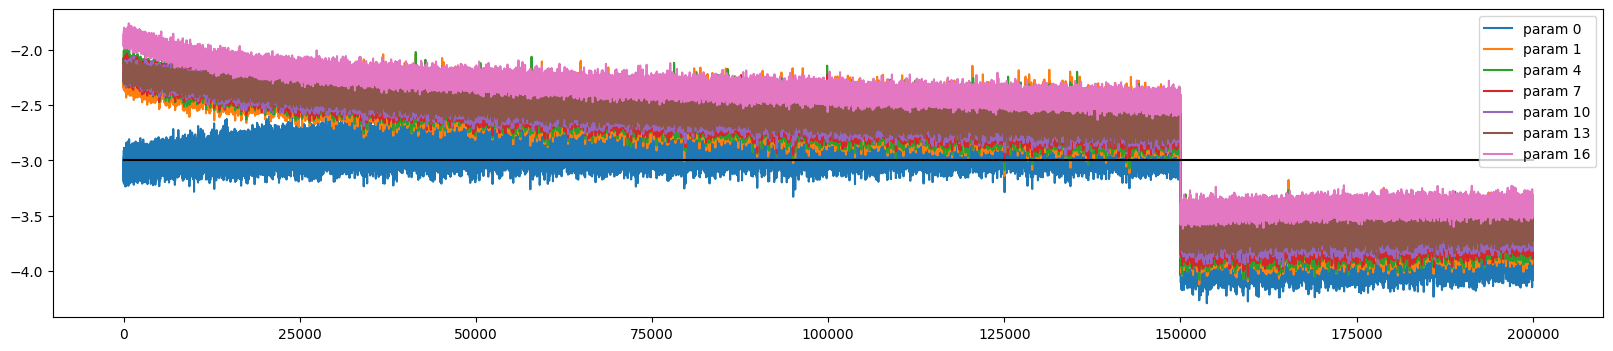

In [21]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9590489864349365
val 2.0822744369506836


In [23]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(decode(i) for i in out)) # decode and print the generated word

montaymyah.
see.
med.
ryla.
reisha.
ejd.
legrazeem.
melin.
shi.
jenneden.
est.
aarvelyza.
houra.
noshubergiagrace.
kin.
renlee.
xithana.
ubakard.
ryyah.
fael.
